## Bibliographic information for resume
This script uses as input a bibtex file and creates a sumamry of research products contained therein. Then, it connects to Google Scholar and created an overview of citations and h-index for an author, added as input.   

In [1]:
import bibtexparser
import pandas as pd
from pybtex.database.input import bibtex
import seaborn as sns
from scholarly import scholarly
import csv
import warnings
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm as CM
from datetime import date
import re

The first step is to import and parse the bibtex file. Please format the Bibtex file so that there are these categories: 
- **article**: peer-reviewed article in international journal
- **periodical**: other type of manuscript
- **book**: book chapter or book
- **dataset**: open-access dataset
- **misc**: open-access presentations

In [2]:
# Insert the file name
filename='sample.bib'

# Parses the bibtex file and imports into a dataframe
parser = bibtexparser.bparser.BibTexParser(common_strings=True,ignore_nonstandard_types=False)
with open(filename) as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file, parser)

# Create dataframe
df = pd.DataFrame(bib_database.entries)
df=df.sort_values(by=['year']).rename(columns = {'ENTRYTYPE':'Type of product'})
df = df.astype({'year': str})

# Edit "Type of products" name for misc and set to presentation
df['Type of product'].replace({'misc':'presentation'},inplace=True)


From the dataframe, a text file is written reporting on publication numbers. The text will be included in the latex resume.

In [3]:
# Write txt file with summary of scientific products
counts = df['Type of product'].value_counts()
filename = 'research_products.txt'
# Write the counts to the file that will be then imported in latex
with open(filename, 'w') as file:
  file.write(f'I have published {counts.article} papers in international scientific journals and {counts.periodical} articles on other peer-reviewed media. I contributed to {counts.book} book chapters and books. Since 2014, I share my data and code in open-access repositories ({counts.dataset} products) and self-publish my presentations at conferences ({counts.presentation} presentations).')

Then, a histogram plot is created only with articles, periodicals, books and open-access datasets. This shows the scientific production by year.

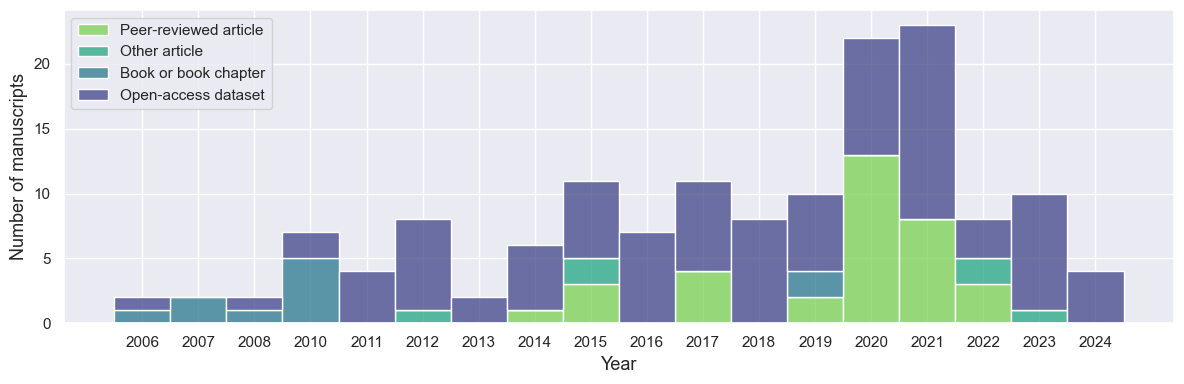

In [4]:
df_filtered = df[df['Type of product'].isin(['article', 'periodical', 'book', 'dataset'])]

plt.figure(figsize=(12, 4))
sns.set(font_scale=1)

# Plot publications
articles = sns.histplot(df_filtered,
                        x='year',
                        hue='Type of product',
                        multiple='stack',
                        palette='viridis',
                        discrete=True)

# Set labels
articles.set_xlabel('Year', fontsize=13)
articles.set_ylabel("Number of manuscripts", fontsize=13)

# Customize legend entries
legend_labels = ['Peer-reviewed article', 'Other article', 'Book or book chapter', 'Open-access dataset']  
plt.legend(legend_labels, loc='upper left')

plt.tight_layout()
plt.savefig('img/products_per_year.png', format='png', transparent=True)
plt.show()

df_filtered.to_csv('img/products.csv', index=False)  

After this, the dataframe exported from the bibtex file is explored to produce statistics on own papers and papers authored by students. For this to work, it is necessary to type in your own surname, and to format the student surnames in the original bibtex file with this format: *\underline{Student Name}*

/var/folders/yt/ph2vgh2x537141y3jl9pwcc00000gn/T/ipykernel_10597/926013319.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['author'] = df['author'].astype(str)


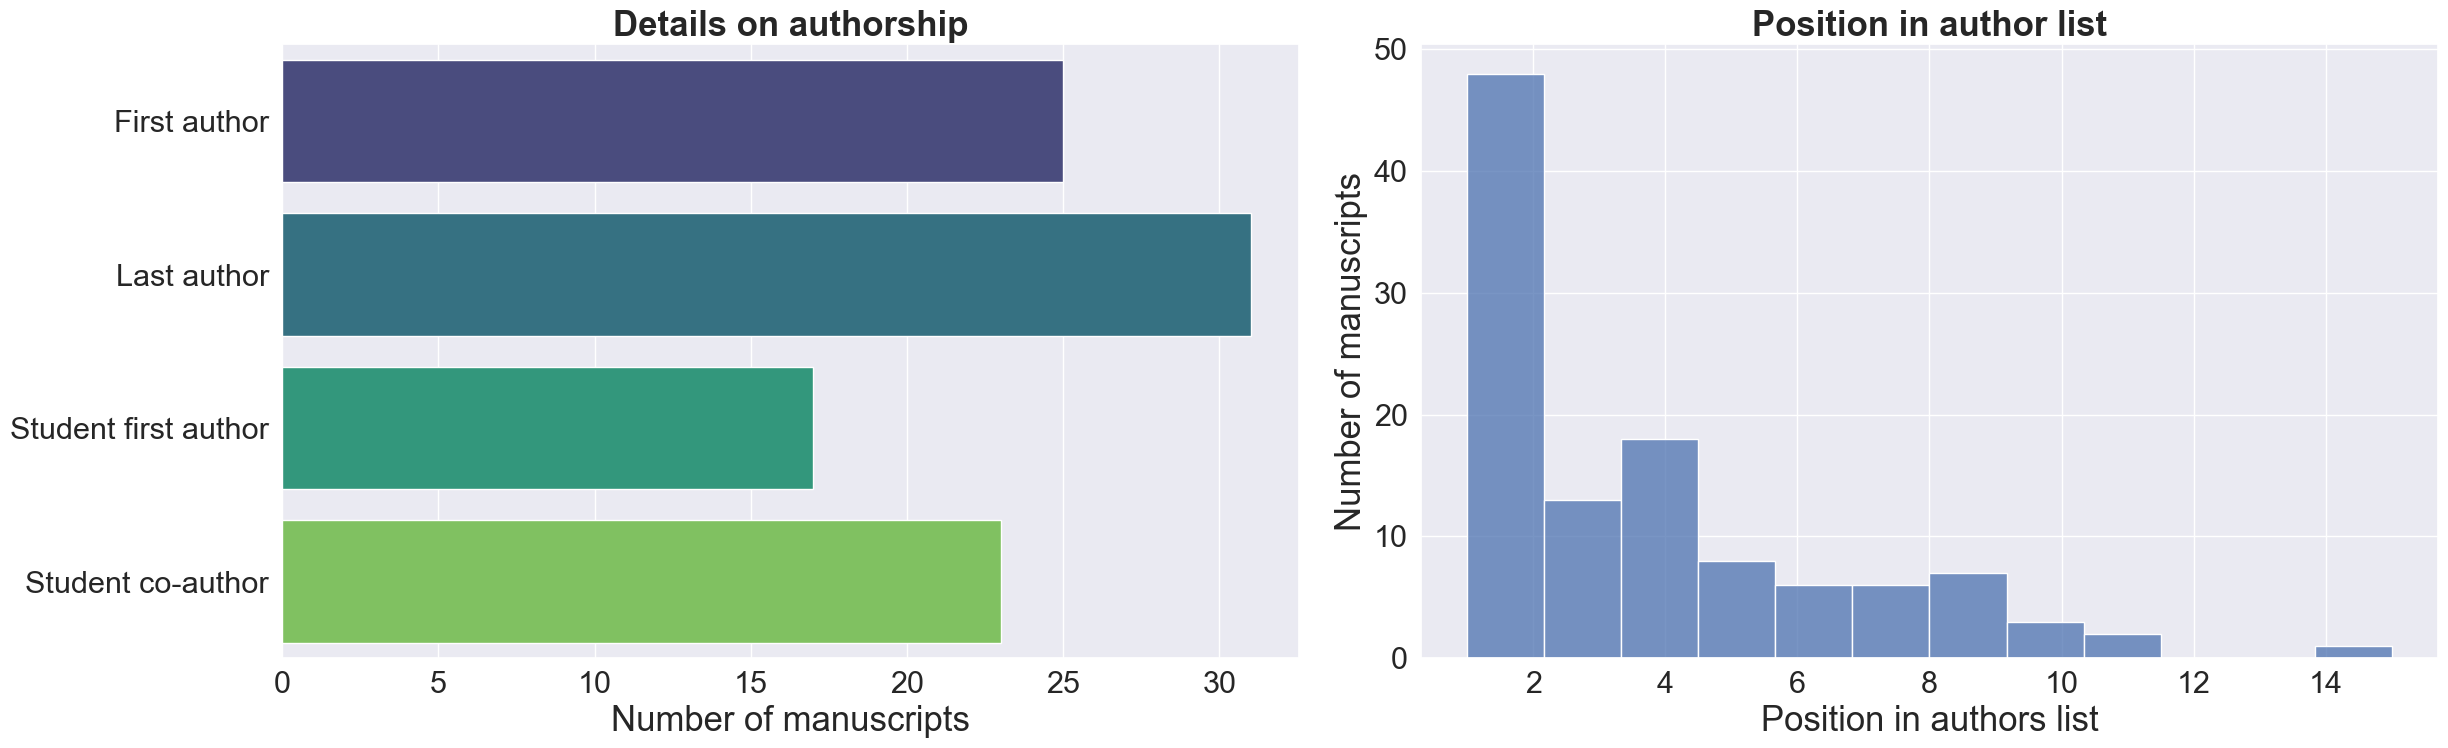

In [5]:
# This part of the code was made via interaction with CHATGPT

# Your surname
your_surname = 'Rovere'


df=df_filtered[df_filtered['Type of product'].isin(['article', 'periodical', 'book'])]

df['author'] = df['author'].astype(str)

# Extract student surnames from the 'Authors' column
student_surnames = set()
for authors in df['author']:
    # Use regular expression to find surnames marked as underlined
    students = re.findall(r'\\underline\{(.*?)\}', authors)
    student_surnames.update(students)

# Initialize counters
papers_as_first_author = 0
papers_as_last_author = 0
papers_by_students_as_first_author = 0
papers_by_students_as_coauthor = 0

# Iterate over each row
for index, row in df.iterrows():
    authors = row['author'].split(' and ')
    first_author = authors[0]
    last_author = authors[-1]

    # Check if you are the first or last author
    if your_surname in first_author:
        papers_as_first_author += 1
    elif your_surname in last_author:
        papers_as_last_author += 1
    
    # Check if any student is the first author
    for author in authors:
        for student_surname in student_surnames:
            if student_surname in author:
                if author == first_author:
                    papers_by_students_as_first_author += 1
                else:
                    papers_by_students_as_coauthor += 1
                break

# Create a DataFrame with the results
results = pd.DataFrame({
    'First author': [papers_as_first_author],
    'Last author': [papers_as_last_author],
    'Student first author': [papers_by_students_as_first_author],
    'Student co-author': [papers_by_students_as_coauthor]
})

# Initialize an empty list to store positions
positions = []

# Iterate over each row
for index, row in df.iterrows():
    authors = row['author'].split(' and ')

    # Search for your surname in the list of authors
    for i, author in enumerate(authors, start=1):
        if your_surname in author:
            positions.append(i)
            break
    else:
        positions.append(None)  # If your surname is not found, append None

# Create a DataFrame with the results
position_df = pd.DataFrame({
    'Position': positions
})

# Create a figure with subplots
sns.set(font_scale=2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))

# Bar plot for results
sns.barplot(y=results.columns, x=results.values.reshape(-1), palette='viridis', ax=axes[0])
axes[0].set_xlabel('Counts')
axes[0].set_ylabel('')
axes[0].tick_params(axis='x')
axes[0].set_xlabel("Number of manuscripts", fontsize = 25)

# Histogram for position_df
sns.histplot(position_df['Position'].dropna(), kde=False, ax=axes[1])
axes[1].set_xlabel('Position in authors list',fontsize = 25)
axes[1].set_ylabel('Number of manuscripts',fontsize = 25)

axes[0].set_title('Details on authorship', fontdict={'fontsize': 25}, fontweight="bold")
axes[1].set_title('Position in author list', fontdict={'fontsize': 25}, fontweight="bold")
plt.tight_layout()
plt.savefig('img/authorship.png', format='png', transparent=True)

# Show the plot
plt.show()

position_df.to_csv('img/authorposition.csv',index=False)
results.to_csv('img/students_ms.csv',index=False)

In the following section, Google Scholar is queried to obtain citation metrics. It is necessary to add the data required in the first cell.

In [7]:
# The following is modified from: https://github.com/ubcbraincircuits/scholar_metrics_scraper
author_names=['Alessio Rovere']
affiliations = ['Ca Foscari University of Venice - DAIS']
First_Publication_year=2011

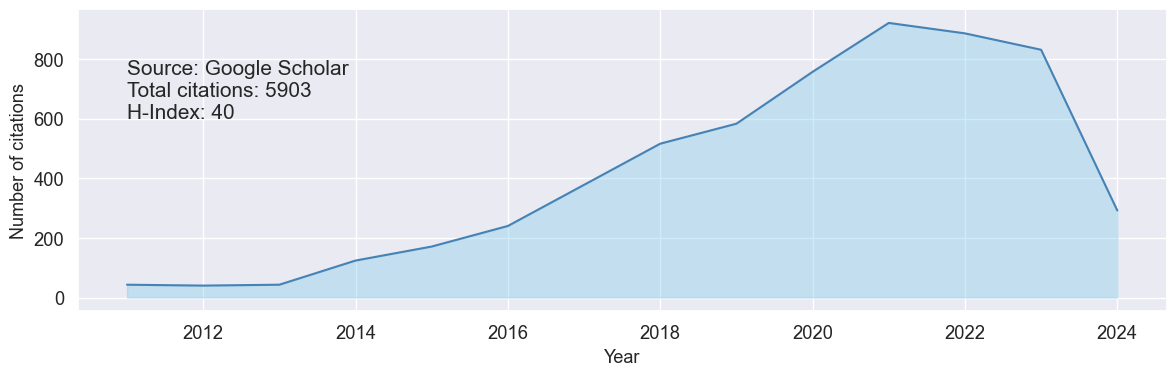

In [8]:
# This will contain all the data for each author which will be exported as a table. It will be a list of dictionaries. 
rows = []
# This will contain a list of dictionaries for each author. The dictionaries will be made up of years as keys and citation numbers as vals
cites_per_year = []
# This dictionary will contain publication titles as keys and author names as values
pub_authors = {}


for athr in author_names:
    pubs = []
    try :
        if ' ' in athr:
            search_query = scholarly.search_author(athr)
            author = next(search_query) 
        else:
            author = scholarly.search_author_id(athr)
    except (RuntimeError,TypeError,StopIteration):
        row = {'Name': athr, 'Warning': 'no information found'}
    else:
        data_dict = scholarly.fill(author, sections=['basics', 'indices', 'publications', 'counts'])
        
        # Get publications titles 
        for pub in data_dict['publications']:
            pubs.append(pub['bib']['title'])
            # Add to dictionary with title as key and author as value
            pub_authors.setdefault(pub['bib']['title'],[]).append(data_dict['name'])
        
        # Get citations per year and put in dictionary
        cites_per_year_dict = data_dict['cites_per_year']
        # Add name to dictionary 
        cites_per_year_dict['name'] = data_dict['name']
        cites_per_year.append(cites_per_year_dict)
        
        # Create row (dictionary) for output data table
        row = {'Name': data_dict['name'], 'Scholar ID': data_dict['scholar_id'], 
               'Cited by': data_dict.get('citedby', ''), 'Cited by 5 years': data_dict.get('citedby5y',''), 
               'h-index': data_dict.get('hindex',''), 'h-index 5 years': data_dict.get('hindex5y',''), 
               'i10-index': data_dict.get('i10index',''),'i10-index 5 years': data_dict.get('i10index5y',''), 
               'Publications': pubs, 'Document Count': len(pubs), 'Affiliation': data_dict['affiliation']}
        
        # Create list of authors who do not have the specified affiliation
        if not any(a in data_dict['affiliation'] for a in affiliations):
            row['Warning'] = "Affiliation does not match!"
            
    finally:    
        rows.append(row)   
        
current_year = date.today().year
years_list=num_list = list(range(First_Publication_year,current_year+1))

# Create citations per year dataframe
cites_df = pd.DataFrame(cites_per_year)

# Add a totals column
cites_df.loc['Total']= cites_df.sum()

# Select years to plot
cites_df_selected = cites_df[years_list]

# Select the last row (totals) 
cites_df_total = cites_df_selected.iloc[-1:]

# Create barplot
years = list(cites_df_total.columns)
cites = cites_df_total.values.tolist()[0]

plt.figure(figsize=(12, 4))  # Adjusted figure size
sns.set(font_scale=1.2)

# Plot citations per year
citations = sns.lineplot(x=years, y=cites, color='steelblue')
plt.fill_between(years, cites, color="skyblue", alpha=0.4)  # Fill area under the line

citations.set_xlabel("Year", fontsize=13)
citations.set_ylabel("Number of citations", fontsize=13)

text = str('Source: Google Scholar \nTotal citations: ' + str(data_dict.get('citedby')) + '\nH-Index: ' + str(data_dict.get('hindex')))
plt.text(2011, 600, text, fontsize=15)  # Adjusted text position

plt.tight_layout()
plt.savefig('img/citations.png', format='png', transparent=True)  # Adjusted dpi
plt.show()
